# Disclaimer:
- The token for some reason are not being displayed in the repository, but they weere <PAD>, <START> and <END>

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...

Epoch 1/10
Batch 0, Loss: 4.1692
Batch 100, Loss: 2.9881
Train Loss: 3.0579 | Train Perplexity: 15.63
Valid Loss: 2.7504 | Valid Perplexity: 15.68
Learning Rate: 0.001000
------------------------------------------------------------
New best model saved! Validation Perplexity: 15.68
Epoch 2/10
Batch 0, Loss: 2.7322
Batch 100, Loss: 2.3787
Train Loss: 2.4240 | Train Perplexity: 13.41
Valid Loss: 2.5049 | Valid Perplexity: 11.93
Learning Rate: 0.001000
------------------------------------------------------------
New best model saved! Validation Perplexity: 11.93
Epoch 3/10
Batch 0, Loss: 2.1135
Batch 100, Loss: 1.8925
Train Loss: 1.9158 | Train Perplexity: 9.05
Valid Loss: 2.1751 | Valid Perplexity: 9.42
Learning Rate: 0.001000
------------------------------------------------------------
New best model saved! Validation Perplexity: 9.42
Epoch 4/10
Batch 0, Loss: 1.6955
Batch 100, Loss: 1.3857
Train Loss: 1.4126 | Train Perplexity: 5.77
Valid Loss: 1.8248 | Valid Perp

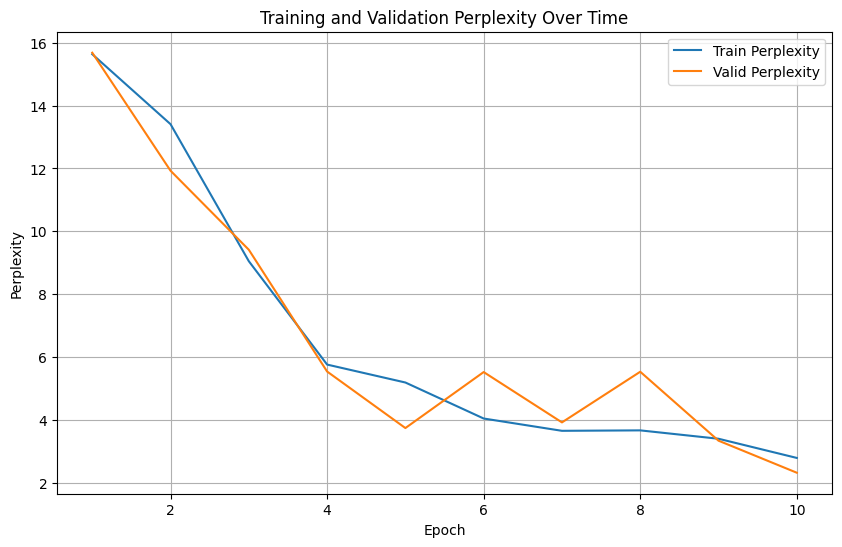

<ipython-input-14-0e07a1252ade>:490: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load('best_model.pt')



Best model achieved validation perplexity: 2.33

Testing best model:

Original: This product is absolutely amazing!
Inverted: Finally found the perfect Timberland boots! Great features and setup was straightforward. My entire 

Original: Worst purchase ever!
Inverted: Finally found the perfect Timberland boots! Great features and setup was straightforward. My entire 

Original: The quality is excellent
Inverted: After a week of using this Timberland boots, I can confidently say it's worth every penny. Build qua


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class ImprovedCharacterTokenizer:
    def __init__(self):
        self.char_to_idx = {'<PAD>': 0, '<START>': 1, '<END>': 2} # <PAD>, <START> and <END>
        self.idx_to_char = {0: '<PAD>', 1: '<START>', 2: '<END>'} # <PAD>, <START> and <END>
        self.vocab_size = 3

    def fit(self, texts):
        unique_chars = set(''.join(texts))
        for char in sorted(unique_chars):
            if char not in self.char_to_idx:
                self.char_to_idx[char] = self.vocab_size
                self.idx_to_char[self.vocab_size] = char
                self.vocab_size += 1

    def encode(self, text):
        return torch.tensor(
            [self.char_to_idx['<START>']] + # <START>
            [self.char_to_idx.get(c, 0) for c in text] +
            [self.char_to_idx['<END>']] #<END>
        )

    def decode(self, indices):
        text = []
        for idx in indices:
            if idx.item() in [0, 1, 2]:  # Skip special tokens
                continue
            text.append(self.idx_to_char.get(idx.item(), ''))
        return ''.join(text)

class ReviewDataset(Dataset):
    def __init__(self, reviews, reversed_reviews, tokenizer):
        self.reviews = reviews
        self.reversed_reviews = reversed_reviews
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        reversed_review = self.reversed_reviews[idx]

        input_tensor = self.tokenizer.encode(review)
        target_tensor = self.tokenizer.encode(reversed_review)

        return input_tensor, target_tensor

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers=1, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Improve embedding with better initialization
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )

        # Add normalization and adaptive dropout
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))

        # Pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, src_len.cpu(), batch_first=True, enforce_sorted=False)

        # Process through LSTM
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        # Apply layer normalization
        outputs = self.layer_norm(outputs)

        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers=1, dropout=0.1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        nn.init.xavier_uniform_(self.embedding.weight)

        # LSTM with better initialization
        self.lstm = nn.LSTM(
            embed_size + hidden_size * 2,
            hidden_size,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Layers for attention
        self.attention = nn.Linear(hidden_size * 3, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

        # Output layers
        self.fc_out = nn.Sequential(
            nn.Linear(hidden_size * 3, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, vocab_size)
        )

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size * 3)

    def compute_attention(self, hidden, encoder_outputs):
        # hidden: [n_layers, batch_size, hidden_size]
        # encoder_outputs: [batch_size, src_len, hidden_size * 2]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Get last hidden state
        hidden = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_size]

        # Repeat hidden for each position of encoder_outputs
        hidden = hidden.repeat(1, src_len, 1)  # [batch_size, src_len, hidden_size]

        # Calculate energy
        energy = torch.tanh(self.attention(
            torch.cat((hidden, encoder_outputs), dim=2)
        ))

        # Calculate attention scores
        v = self.v.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, hidden_size]
        attention = torch.bmm(energy, v.transpose(1, 2))

        # Normalize scores
        attention_weights = F.softmax(attention.squeeze(2), dim=1)

        # Apply attention to encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        return context, attention_weights

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, embed_size]

        # Calculate attention
        context, attention = self.compute_attention(hidden, encoder_outputs)

        # Combine embedding and context
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # Prepare prediction
        prediction_input = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        prediction_input = self.layer_norm(prediction_input)
        prediction = self.fc_out(prediction_input)

        return prediction, hidden, cell, attention

class SentimentInverter(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, n_layers=2, dropout=0.2):
        super().__init__()

        self.encoder = Encoder(vocab_size, embed_size, hidden_size, n_layers, dropout)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size, n_layers, dropout)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        # Get encoder outputs
        encoder_outputs, hidden, cell = self.encoder(src, src_len)

        # Prepare initial decoder input
        decoder_input = trg[:, 0]
        decoder_hidden = hidden[:self.decoder.lstm.num_layers]
        decoder_cell = cell[:self.decoder.lstm.num_layers]

        for t in range(1, trg_len):
            output, decoder_hidden, decoder_cell, _ = self.decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)

            outputs[:, t] = output

            # Teacher forcing with decreasing probability
            teacher_force = np.random.random() < max(
                0.2, teacher_forcing_ratio * (1.0 - t/trg_len))

            decoder_input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

def train_epoch(model, iterator, optimizer, criterion, clip=1.0):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(model.device)
        trg = trg.to(model.device)

        src_len = torch.tensor([len(s) for s in src])

        optimizer.zero_grad()
        output = model(src, src_len, trg)

        loss = criterion(
            output[:, 1:].reshape(-1, output.shape[-1]),
            trg[:, 1:].reshape(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        if i % 100 == 0:
            print(f'Batch {i}, Loss: {loss.item():.4f}')

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in iterator:
            src = src.to(model.device)
            trg = trg.to(model.device)

            src_len = torch.tensor([len(s) for s in src])

            output = model(src, src_len, trg, teacher_forcing_ratio=0)

            loss = criterion(
                output[:, 1:].reshape(-1, output.shape[-1]),
                trg[:, 1:].reshape(-1)
            )

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def collate_fn(batch):
    src_tensors, trg_tensors = zip(*batch)

    # Pad sequences
    src_padded = nn.utils.rnn.pad_sequence(src_tensors, batch_first=True, padding_value=0)
    trg_padded = nn.utils.rnn.pad_sequence(trg_tensors, batch_first=True, padding_value=0)

    return src_padded, trg_padded
def calculate_perplexity(model, iterator, criterion):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for src, trg in iterator:
            src = src.to(model.device)
            trg = trg.to(model.device)

            src_len = torch.tensor([len(s) for s in src])
            output = model(src, src_len, trg, teacher_forcing_ratio=0)

            # Ignore the start token in the calculation
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)

            # Calculate loss only for non-padding tokens
            non_pad_mask = trg != 0
            num_tokens = non_pad_mask.sum().item()

            loss = criterion(output[non_pad_mask], trg[non_pad_mask])

            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens

    # Calculate perplexity
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))

    return perplexity.item()

def invert_text(model, text, tokenizer, max_len=100):
    model.eval()

    with torch.no_grad():
        # Tokenize and move to device
        src_tensor = tokenizer.encode(text).unsqueeze(0).to(model.device)
        src_len = torch.tensor([len(src_tensor[0])])

        # Get encoder outputs - now with hidden and cell states
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

        # Start with start token
        decoder_input = torch.tensor([tokenizer.char_to_idx['<START>']]).to(model.device)

        # Initialize decoder states
        decoder_hidden = hidden[:model.decoder.lstm.num_layers]
        decoder_cell = cell[:model.decoder.lstm.num_layers]

        result = []
        for _ in range(max_len):
            # Updated to use LSTM states
            output, decoder_hidden, decoder_cell, _ = model.decoder(
                decoder_input,
                decoder_hidden,
                decoder_cell,
                encoder_outputs
            )

            # Get predicted token
            decoder_input = output.argmax(1)

            # Convert token to character
            char_idx = decoder_input.item()

            # Stop if end token
            if char_idx == tokenizer.char_to_idx['<END>']:
                break

            result.append(tokenizer.idx_to_char[char_idx])

        return ''.join(result)

# Training function
def train_model(train_loader, val_loader, vocab_size, n_epochs=10):
    model = SentimentInverter(vocab_size)

    # Optimizer with better configuration
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        betas=(0.9, 0.98),
        eps=1e-9,
        weight_decay=0.01
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')

    best_valid_perplexity = float('inf')
    training_history = []
    patience = 5
    patience_counter = 0

    print("Starting training...\n")

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        train_perplexity = calculate_perplexity(model, train_loader, criterion)

        # Validation
        valid_loss = evaluate(model, val_loader, criterion)
        valid_perplexity = calculate_perplexity(model, val_loader, criterion)

        # Adjust the pace of learning
        scheduler.step(valid_perplexity)

        # Save metrics
        metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_perplexity': train_perplexity,
            'valid_loss': valid_loss,
            'valid_perplexity': valid_perplexity,
            'learning_rate': optimizer.param_groups[0]['lr']
        }
        training_history.append(metrics)

        print(f'Train Loss: {train_loss:.4f} | Train Perplexity: {train_perplexity:.2f}')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Perplexity: {valid_perplexity:.2f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Early stopping with better criterion
        if valid_perplexity < best_valid_perplexity:
            best_valid_perplexity = valid_perplexity
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_perplexity': train_perplexity,
                'valid_perplexity': valid_perplexity,
                'training_history': training_history
            }, 'best_model.pt')
            print(f'New best model saved! Validation Perplexity: {valid_perplexity:.2f}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    return model, training_history

# Function to visualize the training metrics
def plot_training_metrics(history):
    import matplotlib.pyplot as plt

    epochs = [m['epoch'] for m in history]
    train_perp = [m['train_perplexity'] for m in history]
    valid_perp = [m['valid_perplexity'] for m in history]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_perp, label='Train Perplexity')
    plt.plot(epochs, valid_perp, label='Valid Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training and Validation Perplexity Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Load data
    df = pd.read_csv('amazon_reviews.csv')

    # Create tokenizer
    tokenizer = ImprovedCharacterTokenizer()
    tokenizer.fit(df['review'].tolist() + df['reversed'].tolist())

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        df['review'].tolist(),
        df['reversed'].tolist(),
        test_size=0.1
    )

    # Create datasets
    train_dataset = ReviewDataset(X_train, y_train, tokenizer)
    val_dataset = ReviewDataset(X_val, y_val, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Train model with perplexity tracking
    model, history = train_model(train_loader, val_loader, tokenizer.vocab_size)

    # Plot training metrics
    plot_training_metrics(history)

    # Load best model and test it
    best_checkpoint = torch.load('best_model.pt')
    best_model = SentimentInverter(tokenizer.vocab_size)
    best_model.load_state_dict(best_checkpoint['model_state_dict'])

    print(f"\nBest model achieved validation perplexity: {best_checkpoint['valid_perplexity']:.2f}")

    # Test examples
    test_reviews = [
        "This product is absolutely amazing!",
        "Worst purchase ever!",
        "The quality is excellent"
    ]

    print("\nTesting best model:")
    for review in test_reviews:
        inverted = invert_text(best_model, review, tokenizer)
        print(f"\nOriginal: {review}")
        print(f"Inverted: {inverted}")